In [10]:
from glob import glob
import os

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib import cm
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from rasterio.plot import plotting_extent
from shapely.geometry import box
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
import scipy.io
from scipy.io import loadmat
import pandas as pd
import h5py
import geopandas as gpd
# optional - turn off warnings
import warnings
warnings.filterwarnings('ignore')

os.chdir('/users/marianne/documents/pe_snow_fires/')

In [4]:
#### define functions

def distance(P1, P2):
    return ((P1[0] - P2[0])**2 + (P1[1] - P2[1])**2) ** 0.5


def optimized_path(coords, start=None):
    if start is None:
        start = coords[0]
    pass_by = coords
    path = [start]
    pass_by.remove(start)
    while pass_by:
        nearest = min(pass_by, key=lambda x: distance(path[-1], x))
        path.append(nearest)
        pass_by.remove(nearest)
    return path

import numpy as np
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA

from scipy import interpolate

def XYclean(x,y): 

    xy = np.concatenate((x.reshape(-1,1), y.reshape(-1,1)), axis=1)     

    # make PCA object
    pca = PCA(2)
    # fit on data
    pca.fit(xy)
    
    #transform into pca space   
    xypca = pca.transform(xy) 
    newx = xypca[:,0]
    newy = xypca[:,1]

    #sort
    indexSort = np.argsort(x)
    newx = newx[indexSort]
    newy = newy[indexSort]

    #add some more points (optional)
    f = interpolate.interp1d(newx, newy, kind='linear')        
    newX=np.linspace(np.min(newx), np.max(newx), 100)
    newY = f(newX)            

    #smooth with a filter (optional)
    window = 43
    newY = savgol_filter(newY, window, 2)

    #return back to old coordinates
    xyclean = pca.inverse_transform(np.concatenate((newX.reshape(-1,1), newY.reshape(-1,1)), axis=1) )
    xc=xyclean[:,0]
    yc = xyclean[:,1]

    return xc, yc


def order_points(points, ind):
    points_new = [ points.pop(ind) ]  # initialize a new list of points with the known first point
    pcurr      = points_new[-1]       # initialize the current point (as the known point)
    while len(points)>0:
        d      = np.linalg.norm(np.array(points) - np.array(pcurr), axis=1)  # distances between pcurr and all other remaining points
        ind    = d.argmin()                   # index of the closest point
        points_new.append( points.pop(ind) )  # append the closest point to points_new
        pcurr  = points_new[-1]               # update the current point
    return points_new


In [11]:
filepath = '/users/marianne/documents/pe_snow_fires/data/watershed_masks/'
files = os.listdir(filepath)
tmp_list=[]
outlines_list=[]
for f in files[0:1]:
    try:
        mask = h5py.File(filepath + f)
        name = f.split('_watershed')[0]
        outline = mask[name+'_watershed_outline_coords']
        xs =outline['x'][0]
        ys = outline['y'][0]
        new_xs, new_ys = XYclean(xs,ys)

        # find the leftmost point:
        ind    = xs.argmin()

        # assemble the x and y coordinates into a list of (x,y) tuples:
        points = [(xx,yy)  for xx,yy in zip(xs,ys)]

        # order the points based on the known first point:
        points_new = order_points(points, ind)
        xn,yn  = np.array(points_new).T

        poly = Polygon(zip(xn,yn))
        tmp_list.append({'geometry': poly,'name':name})
    except:
        continue
'''
#just for the cosumnes because the matlab file is a different version
mask = loadmat(filepath + 'cosumnes_watershed_mask.mat')
name = 'cosumnes'
outline = mask[name+'_watershed_outline_coords']
xs = outline['x'][0][0]
ys = outline['y'][0][0]

new_xs, new_ys = XYclean(xs,ys)
# find the leftmost point:
ind    = xs.argmin()
# assemble the x and y coordinates into a list of (x,y) tuples:
points = [(xx,yy)  for xx,yy in zip(xs,ys)]
# order the points based on the known first point:
points_new = order_points(points, ind)
xn,yn  = np.array(points_new).T
poly = Polygon(zip(xn,yn))
tmp_list.append({'geometry': poly,'name':name})
'''
gdf = gpd.GeoDataFrame(tmp_list,crs=4326)
gdf.to_file('watersheds.gdf')

In [12]:
watersheds=gpd.read_file('watersheds.gdf')

In [14]:
watersheds.geometry

0    POLYGON ((-121.17542 38.73486, -121.17514 38.7...
Name: geometry, dtype: geometry

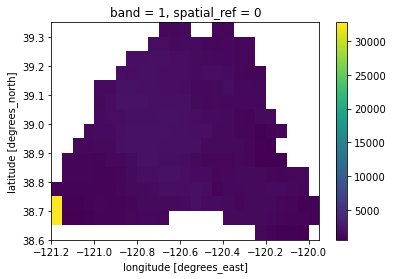

In [22]:
import earthpy.plot as ep
from rasterio.plot import plotting_extent
fp = os.path.join('/users/marianne/earth-analytics/data/MOD17/GeoTiff/Monthly_MOD17A2/MOD17A2_GPP.2004.M08.tif')
modis_pre = rxr.open_rasterio(fp,
                              masked=True)
modis_clip = modis_pre.rio.clip(watersheds.geometry,
                    all_touched=True)
fig,ax=plt.subplots()
modis_clip.plot()
plt.show()
    

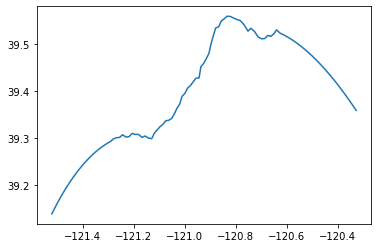

In [60]:
plt.plot(new_xs, new_ys)

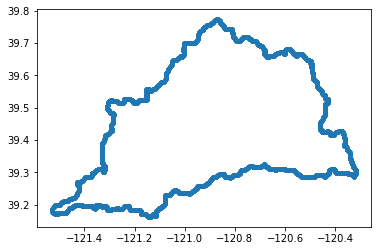

In [59]:
plt.plot(xs,ys,'.')

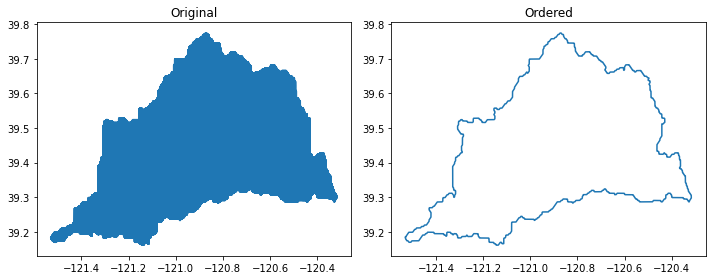

In [63]:



points = np.load("/Users/imalsky/Desktop/isaac.npy")
xs = points[0]
ys = points[1]

# plot:
fig,ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(xs, ys)  # original (shuffled) points
ax[1].plot(xn, yn)  # new (ordered) points
ax[0].set_title('Original')
ax[1].set_title('Ordered')
plt.tight_layout()
plt.show()

In [65]:
!pip install geopandas
import geopandas as gpd
from shapely.geometry import Polygon

In [76]:
tmp_list=[]
name = 'name'
poly = Polygon(zip(xn,yn))#.boundary
tmp_list.append({'geometry': poly,'name':name})


In [77]:
gdf = gpd.GeoDataFrame(tmp_list,crs=4326)
gdf.to_file('watershed_test.gdf')

In [78]:
test = gpd.read_file('watershed_test.gdf')

In [79]:
test

,name,geometry
0,name,"POLYGON ((-121.52958 39.18486, -121.52931 39.1..."


In [80]:
test['geometry']

0    POLYGON ((-121.52958 39.18486, -121.52931 39.1...
Name: geometry, dtype: geometry